In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib

In [390]:
import os
import logging
import argparse
import glob
import json

import numpy as np
from matplotlib.ticker import StrMethodFormatter

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
import pandas as pd
from astropy.table import Table  # for NSA
from astropy import units as u
from sklearn.metrics import confusion_matrix, roc_curve
from PIL import Image
from scipy.stats import binom
from IPython.display import display, Markdown
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, confusion_matrix

from shared_astro_utils import astropy_utils, matching_utils
from zoobot.estimators import make_predictions, bayesian_estimator_funcs
from zoobot.tfrecord import read_tfrecord
from zoobot.uncertainty import discrete_coverage
from zoobot.estimators import input_utils, losses
from zoobot.tfrecord import catalog_to_tfrecord
from zoobot.active_learning import metrics, simulated_metrics, acquisition_utils, check_uncertainty, simulation_timeline, run_estimator_config


In [4]:
os.chdir('/home/walml/repos/zoobot')

In [5]:
label_cols = [
    'smooth-or-featured_smooth',
    'smooth-or-featured_featured-or-disk',
    'has-spiral-arms_yes',
    'has-spiral-arms_no',
#     'spiral-winding_tight',
#     'spiral-winding_medium',
#     'spiral-winding_loose',
    'bar_strong',
    'bar_weak',
    'bar_no',
    'bulge-size_dominant',
    'bulge-size_large',
    'bulge-size_moderate',
    'bulge-size_small',
    'bulge-size_none'
]

questions = [
    'smooth-or-featured',
    'has-spiral-arms',
#     'spiral-winding',
    'bar',
    'bulge-size'
]

schema = losses.Schema(label_cols, questions, version='decals')
schema.questions

{smooth-or-featured, indices 0 to 1, asked after None: (0, 1), has-spiral-arms, indices 2 to 3, asked after <zoobot.estimators.losses.Answer object at 0x7f67b92e4310>: (2, 3), bar, indices 4 to 6, asked after <zoobot.estimators.losses.Answer object at 0x7f67b92e4310>: (4, 6), bulge-size, indices 7 to 11, asked after <zoobot.estimators.losses.Answer object at 0x7f67b92e4310>: (7, 11)}


[smooth-or-featured, indices 0 to 1, asked after None,
 has-spiral-arms, indices 2 to 3, asked after <zoobot.estimators.losses.Answer object at 0x7f67b92e4310>,
 bar, indices 4 to 6, asked after <zoobot.estimators.losses.Answer object at 0x7f67b92e4310>,
 bulge-size, indices 7 to 11, asked after <zoobot.estimators.losses.Answer object at 0x7f67b92e4310>]

## Load aggregated expert classifications

In [208]:
expert_df = pd.read_csv('../gz-panoptes-reduction/temp/calibration_experts/classifications.csv')

In [209]:
expert_df['iauname']

0      J113200.89+253837.9
1      J112214.40+241758.0
2      J085808.74+061816.4
3      J091427.67+073429.7
4      J120258.33+090325.5
              ...         
141    J143039.56-003854.4
142    J104713.62+012940.1
143    J124559.79+033511.2
144    J132100.97-005739.7
145    J002331.99-005106.5
Name: iauname, Length: 146, dtype: object

In [210]:
expert_df['subject_id']

0      37763488
1      37763455
2      37763393
3      37763390
4      37763537
         ...   
141    37763420
142    37763516
143    37763401
144    37763554
145    37763509
Name: subject_id, Length: 146, dtype: int64

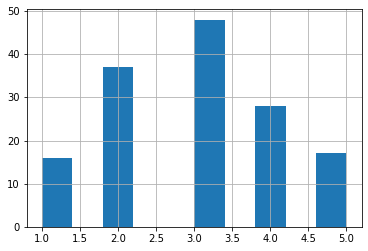

In [211]:
expert_df['smooth-or-featured_total-votes'].hist()

## Get DR5 classifications and filter to calibration galaxies (for speed)

In [331]:
dr5 = pd.read_csv('../gz-panoptes-reduction/data/decals-dr5-classifications.csv')  # in here, uploaded as default (N=40)
# dr5 = pd.read_csv('../gz-panoptes-reduction/data/enhanced-classifications.csv')  # in here, uploaded as random (N=3)

In [332]:
def get_iauname(subject_data):
    data = json.loads(subject_data)
    for subject_id, values in data.items():
        for key in ['iauname', '#iauname', '!iauname']:
            if key in values.keys():
                return values[key]

In [333]:
dr5['iauname'] = dr5['subject_data'].apply(get_iauname)

In [334]:
dr5_expert = dr5['iauname'].isin(expert_df['iauname'])

In [335]:
dr5_expert.sum()

5207

In [337]:
volunteer_export = dr5[dr5_expert]

In [338]:
volunteer_export

,classification_id,user_name,user_id,user_ip,workflow_id,workflow_name,workflow_version,created_at,gold_standard,expert,metadata,annotations,subject_data,subject_ids,iauname
176073,100721018,AdrianC100,1765894.0,0950dbf86d9d0ccb013f,6122,DECaLS DR5,66.403,2018-04-08 20:29:16 UTC,NaN,NaN,"{""session"":""7cc257450299a47746e71904e83b5d14cc...","[{""task"":""T0"",""task_label"":""Is the galaxy simp...","{""20684324"":{""retired"":{""id"":13831423,""workflo...",20684324,J115537.58+000228.3
176776,100741739,lindadriftwood,107263.0,48969f461b5a18d57a0d,6122,DECaLS DR5,66.403,2018-04-08 23:27:25 UTC,NaN,NaN,"{""session"":""2448c90aa715d43a2b7aac8f31fdfbadde...","[{""task"":""T0"",""task_label"":""Is the galaxy simp...","{""20684836"":{""retired"":{""id"":13834418,""workflo...",20684836,J123744.73-004120.4
176782,100741905,lindadriftwood,107263.0,48969f461b5a18d57a0d,6122,DECaLS DR5,66.403,2018-04-08 23:28:45 UTC,NaN,NaN,"{""session"":""2448c90aa715d43a2b7aac8f31fdfbadde...","[{""task"":""T0"",""task_label"":""Is the galaxy simp...","{""20685667"":{""retired"":{""id"":13834439,""workflo...",20685667,J131959.38+005707.7
178071,100770163,docjuker,81363.0,d9d642392a4972bb26fc,6122,DECaLS DR5,66.403,2018-04-09 05:00:07 UTC,NaN,NaN,"{""session"":""3f218e65142c1e660af635b6e94a5f2a94...","[{""task"":""T0"",""task_label"":""Is the galaxy simp...","{""20684836"":{""retired"":{""id"":13834418,""workflo...",20684836,J123744.73-004120.4
178315,100778123,e.valenzuela,1766037.0,34e04e0b914fd659ef20,6122,DECaLS DR5,66.403,2018-04-09 06:51:20 UTC,NaN,NaN,"{""session"":""cc4fe748745ce614b5a0f60d63178b7e83...","[{""task"":""T0"",""task_label"":""Is the galaxy simp...","{""20684836"":{""retired"":{""id"":13834418,""workflo...",20684836,J123744.73-004120.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1913925,152971686,dharnade,1879435.0,edfd2079ef37b749296f,6122,DECaLS DR5,66.425,2019-03-15 18:47:58 UTC,NaN,NaN,"{""source"":""api"",""session"":""670eb28166f249c98a2...","[{""task"":""T0"",""task_label"":""Is the galaxy simp...","{""28483722"":{""retired"":null,""!ra"":153.90289387...",28483722,J101536.68+062052.1
1914286,152992005,CDHunts,1879743.0,5c05afbb99577a05a14a,6122,DECaLS DR5,66.425,2019-03-15 19:53:15 UTC,NaN,NaN,"{""source"":""api"",""session"":""92a43be07a66f3b27e6...","[{""task"":""T0"",""task_label"":""Is the galaxy simp...","{""28485533"":{""retired"":null,""!ra"":158.09299316...",28485533,J103222.31+060011.2
1914303,152992825,CDHunts,1879743.0,5c05afbb99577a05a14a,6122,DECaLS DR5,66.425,2019-03-15 19:55:29 UTC,NaN,NaN,"{""source"":""api"",""session"":""92a43be07a66f3b27e6...","[{""task"":""T0"",""task_label"":""Is the galaxy simp...","{""28486488"":{""retired"":null,""!ra"":168.39860411...",28486488,J111335.65+102212.7
1914411,153002135,Moggsy8,1662467.0,163ee48be79a9d5b0b98,6122,DECaLS DR5,66.425,2019-03-15 20:25:54 UTC,NaN,NaN,"{""source"":""api"",""session"":""6762491e65c5a730551...","[{""task"":""T0"",""task_label"":""Is the galaxy simp...","{""28486390"":{""retired"":null,""!ra"":311.79380914...",28486390,J204710.50+002147.8


In [339]:
del volunteer_export['iauname']  # messes up the schema

In [340]:
volunteer_export.to_csv('../gz-panoptes-reduction/data/volunteer_calibration_export.csv', index=False)

### Process volunteer classifications for this filtered export, see process...md

In [344]:
volunteers_df = pd.read_csv('../gz-panoptes-reduction/temp/calibration_volunteers/classifications.csv')

In [345]:
def get_file_loc(iauname):
    return f'/media/walml/beta/decals/png_native/dr5/{iauname[:4]}/{iauname}.png'

In [346]:
volunteers_df['file_loc'] = volunteers_df['iauname'].apply(get_file_loc)
volunteers_df['id_str'] = volunteers_df['iauname']

In [347]:
volunteers_df['iauname'].sort_values()

63     J002113.62-000424.0
121    J002144.54-005053.9
56     J002331.99-005106.5
13     J002504.59-005352.5
128    J003713.27+004756.9
              ...         
5      J163255.91+235645.1
66     J203824.00+002111.8
76     J204710.50+002147.8
50     J205658.69+001128.3
93     J214833.87-071715.8
Name: iauname, Length: 143, dtype: object

In [348]:
volunteers_df.to_csv('data/decals/temp_calibration_catalog.csv', index=False)  # with volunteer responses

In [349]:
!python make_decals_tfrecords.py --labelled-catalog=data/decals/temp_calibration_catalog.csv --eval-size=1 --shard-dir=data/decals/shards/temp_calibration_shards_feat --img-size 256 --feat

2020-05-12 15:19:29.481256: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2020-05-12 15:19:29.495218: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
['subject_id' 'bar_no' 'bar_strong' 'bar_weak' 'bulge-size_dominant'
 'bulge-size_large' 'bulge-size_moderate' 'bulge-size_none'
 'bulge-size_small' 'disk-edge-on_no' 'disk-edge-on_yes'
 'edge-on-bulge_boxy' 'edge-on-bulge_none' 'edge-on-bulge_rounded'
 'has-spiral-arms_no' 'has-spiral-arms_yes' 'how-rounded_cigar-shaped'
 'how-rounded_in-between' 'how-rounded_round' 'merging_both-v1'
 'merging_major-disturbance' 'merging_merger' 'merging_minor-disturbance'
 'merging_neither-v1' 'merging_none' 'merging_tidal-debris-v1'
 'smooth-or-featured_artifact' 'smooth-or-featured_featured-or-disk'
 'smooth-or-featured_smooth' 'spiral-arm-count_1' 'spiral-arm-count_2'
 'spiral-arm-count_3' 'spiral-arm-count_

## Optionally, check these iaunames do appear in the subject export

In [180]:
subjects = pd.read_csv('../gz-panoptes-reduction/data/latest_subjects_export.csv')

In [181]:
subjects.iloc[0]

subject_id                                                        15069047
project_id                                                            5733
workflow_id                                                            NaN
subject_set_id                                                       16811
metadata                 {"ra":212.68791,"dec":1.04629,"nsa_id":12916,"...
locations                {"0":"https://panoptes-uploads.zooniverse.org/...
classifications_count                                                    0
retired_at                                                             NaN
retirement_reason                                                      NaN
created_at                                         2017-11-29 15:22:03 UTC
updated_at                                         2017-11-29 15:22:03 UTC
Name: 0, dtype: object

In [182]:
def get_subject_iauname(subject_data):
    data = json.loads(subject_data)
    for key in ['iauname', '#iauname', '!iauname']:
        if key in data.keys():
            return data[key]

In [183]:
subjects['iauname'] = subjects['metadata'].apply(get_subject_iauname)

In [184]:
subjects['iauname'].value_counts()

J012607.39-011949.9    9
J211441.06-002054.9    8
J010251.60-013329.0    8
J103012.83-005644.1    8
J095905.51+023809.9    8
                      ..
J094700.73+020426.8    1
J134203.23+032916.2    1
J133855.67-004807.1    1
J105225.96+060616.8    1
J134538.64+000553.2    1
Name: iauname, Length: 262012, dtype: int64

In [185]:
is_expert = subjects['iauname'].isin(expert_df['iauname'])

In [186]:
is_expert.sum()

304

In [187]:
expert_subjects = subjects[is_expert]

In [189]:
expert_subjects.head()

,subject_id,project_id,workflow_id,subject_set_id,metadata,locations,classifications_count,retired_at,retirement_reason,created_at,updated_at,iauname
8647,20684324,5733,6122.0,20156,"{""!ra"":178.9065979881638,""!dec"":0.041202658277...","{""0"":""https://panoptes-uploads.zooniverse.org/...",41,2018-04-18 02:14:15 UTC,classification_count,2018-03-30 11:00:44 UTC,2018-03-30 11:00:44 UTC,J115537.58+000228.3
8749,20684426,5733,6122.0,20156,"{""!ra"":185.0802046337571,""!dec"":-1.09524956288...","{""0"":""https://panoptes-uploads.zooniverse.org/...",40,2018-04-18 15:10:05 UTC,classification_count,2018-03-30 11:00:50 UTC,2018-03-30 11:00:50 UTC,J122019.24-010542.8
9155,20684832,5733,6122.0,20156,"{""!ra"":189.5102332677443,""!dec"":-0.71238729663...","{""0"":""https://panoptes-uploads.zooniverse.org/...",40,2018-04-19 20:07:44 UTC,classification_count,2018-03-30 11:01:16 UTC,2018-03-30 11:01:16 UTC,J123802.45-004244.5
9159,20684836,5733,6122.0,20156,"{""!ra"":189.4364250978784,""!dec"":-0.68900958094...","{""0"":""https://panoptes-uploads.zooniverse.org/...",40,2018-04-18 15:23:54 UTC,classification_count,2018-03-30 11:01:16 UTC,2018-03-30 11:01:16 UTC,J123744.73-004120.4
9277,20684954,5733,6122.0,20156,"{""!ra"":190.8568025710639,""!dec"":-0.08997173611...","{""0"":""https://panoptes-uploads.zooniverse.org/...",40,2018-04-20 03:43:29 UTC,classification_count,2018-03-30 11:01:23 UTC,2018-03-30 11:01:23 UTC,J124325.63-000523.9


In [134]:
# expert_subjects['locations'].apply(lambda x: json.loads(x)["0"]).values

## Optionally, check these subjects do appear in the extracted subjects

In [190]:
subjects_loaded = pd.read_parquet('../gz-panoptes-reduction/temp/latest_subjects.parquet')

In [191]:
assert not any(subjects_loaded['subject_id'].isna())

In [192]:
subjects_loaded['iauname'].value_counts()

J225631.29+174704.0    5
J103723.62+021845.5    5
J000304.29+134501.8    4
J090124.30+101159.0    4
J162255.17+142031.6    4
                      ..
J085225.29+170453.0    1
J005454.75+002601.5    1
J000240.19-004450.9    1
J013401.50+260418.5    1
J141845.23+053510.7    1
Name: iauname, Length: 262012, dtype: int64

In [193]:
expert_loaded = subjects_loaded['iauname'].isin(expert_df['iauname'])

In [194]:
expert_loaded.sum()

298

In [195]:
expert_loaded = subjects_loaded[expert_loaded]

In [196]:
expert_loaded

,subject_id,subject_url,iauname,upload_date,uploader,retirement_limit
7046,20684324,https://panoptes-uploads.zooniverse.org/produc...,J115537.58+000228.3,2018-03-30,None,NaN
7148,20684426,https://panoptes-uploads.zooniverse.org/produc...,J122019.24-010542.8,2018-03-30,None,NaN
7554,20684832,https://panoptes-uploads.zooniverse.org/produc...,J123802.45-004244.5,2018-03-30,None,NaN
7558,20684836,https://panoptes-uploads.zooniverse.org/produc...,J123744.73-004120.4,2018-03-30,None,NaN
7676,20684954,https://panoptes-uploads.zooniverse.org/produc...,J124325.63-000523.9,2018-03-30,None,NaN
...,...,...,...,...,...,...
125798,37763554,https://panoptes-uploads.zooniverse.org/produc...,J132100.97-005739.7,2019-10-23,panoptes_oracle,5.0
125799,37763555,https://panoptes-uploads.zooniverse.org/produc...,J111335.65+102212.7,2019-10-23,panoptes_oracle,5.0
125800,37763556,https://panoptes-uploads.zooniverse.org/produc...,J091932.24-002436.2,2019-10-23,panoptes_oracle,5.0
125801,37763557,https://panoptes-uploads.zooniverse.org/produc...,J113517.25-033739.2,2019-10-23,panoptes_oracle,5.0


## Now let's analyse!

In [350]:
volunteers_df = pd.read_csv('../gz-panoptes-reduction/temp/calibration_volunteers/classifications.csv')

In [351]:
volunteers_df.head()

,subject_id,bar_no,bar_strong,bar_weak,bulge-size_dominant,bulge-size_large,bulge-size_moderate,bulge-size_none,bulge-size_small,disk-edge-on_no,...,merging_both-v1_fraction,merging_neither-v1_fraction,merging_major-disturbance_fraction,merging_minor-disturbance_fraction,merging_none_fraction,subject_url,iauname,upload_date,uploader,retirement_limit
0,20768151,0,0,0,0,0,0,0,0,0,...,0.0,1.000000,0.000000,0.000000,0.000000,https://panoptes-uploads.zooniverse.org/produc...,J113200.89+253837.9,2018-04-09,NaN,NaN
1,26443662,6,0,1,0,0,0,6,1,7,...,0.0,0.000000,0.026316,0.184211,0.763158,https://panoptes-uploads.zooniverse.org/produc...,J104713.62+012940.1,2018-09-28,NaN,NaN
2,26444498,3,0,0,0,0,2,0,1,3,...,0.0,0.000000,0.025641,0.102564,0.846154,https://panoptes-uploads.zooniverse.org/produc...,J122202.43+012341.9,2018-09-28,NaN,NaN
3,20923190,8,1,6,0,1,5,2,7,15,...,0.0,0.689655,0.000000,0.000000,0.000000,https://panoptes-uploads.zooniverse.org/produc...,J142300.69+004226.7,2018-04-19,NaN,NaN
4,21663456,2,0,1,0,0,3,0,0,3,...,0.0,0.179487,0.076923,0.025641,0.692308,https://panoptes-uploads.zooniverse.org/produc...,J011235.69-002452.6,2018-05-16,NaN,NaN


In [352]:
ml_df = pd.read_csv('temp/calibration_predictions.csv')
ml_df = ml_df[['iauname'] + [a.text + '_prediction' for a in schema.answers] + [a.text + '_prediction_mean' for a in schema.answers]]
ml_df.head()

,iauname,smooth-or-featured_smooth_prediction,smooth-or-featured_featured-or-disk_prediction,has-spiral-arms_yes_prediction,has-spiral-arms_no_prediction,bar_strong_prediction,bar_weak_prediction,bar_no_prediction,bulge-size_dominant_prediction,bulge-size_large_prediction,...,has-spiral-arms_yes_prediction_mean,has-spiral-arms_no_prediction_mean,bar_strong_prediction_mean,bar_weak_prediction_mean,bar_no_prediction_mean,bulge-size_dominant_prediction_mean,bulge-size_large_prediction_mean,bulge-size_moderate_prediction_mean,bulge-size_small_prediction_mean,bulge-size_none_prediction_mean
0,J095827.12+053202.9,"[0.3450254201889038, 0.30479463934898376, 0.39...","[0.6549745798110962, 0.6952053904533386, 0.608...","[0.7786278128623962, 0.8500095009803772, 0.700...","[0.22137221693992615, 0.1499904841184616, 0.29...","[0.02487005852162838, 0.11330746114253998, 0.0...","[0.18685849010944366, 0.36131736636161804, 0.1...","[0.788271427154541, 0.5253751873970032, 0.7674...","[0.009098440408706665, 0.012319830246269703, 0...","[0.037743255496025085, 0.034372299909591675, 0...",...,0.787338,0.212662,0.092769,0.336509,0.570721,0.012773,0.044555,0.496052,0.419309,0.027311
1,J110941.14+071441.8,"[0.08003682643175125, 0.1025530993938446, 0.08...","[0.9199631810188293, 0.8974469304084778, 0.910...","[0.8051676750183105, 0.6734292507171631, 0.868...","[0.19483232498168945, 0.3265707194805145, 0.13...","[0.4113297462463379, 0.42520251870155334, 0.25...","[0.46923506259918213, 0.41790667176246643, 0.5...","[0.1194351315498352, 0.15689074993133545, 0.17...","[0.004876687657088041, 0.00576606672257185, 0....","[0.01144727785140276, 0.022490520030260086, 0....",...,0.834448,0.165552,0.343783,0.502387,0.153831,0.004817,0.016683,0.302045,0.580433,0.096022
2,J093958.09+015709.4,"[0.09729380160570145, 0.10157424956560135, 0.0...","[0.9027062058448792, 0.8984256982803345, 0.933...","[0.9475104212760925, 0.9266517162322998, 0.946...","[0.05248962715268135, 0.0733482837677002, 0.05...","[0.23868361115455627, 0.3454155921936035, 0.43...","[0.32898783683776855, 0.3356339931488037, 0.34...","[0.4323284924030304, 0.3189504146575928, 0.215...","[0.008311137557029724, 0.01008316595107317, 0....","[0.062162671238183975, 0.08302217721939087, 0....",...,0.942493,0.057507,0.297989,0.351566,0.350445,0.007794,0.058494,0.559477,0.363848,0.010387
3,J124558.63-022016.8,"[0.0973023772239685, 0.07113342732191086, 0.12...","[0.9026975631713867, 0.9288665652275085, 0.877...","[0.8264166116714478, 0.895691990852356, 0.8152...","[0.17358334362506866, 0.10430800169706345, 0.1...","[0.05856238678097725, 0.08202864974737167, 0.2...","[0.20573413372039795, 0.28753671050071716, 0.4...","[0.7357034683227539, 0.6304346323013306, 0.347...","[0.01753147691488266, 0.016825733706355095, 0....","[0.2540201246738434, 0.21038715541362762, 0.22...",...,0.765977,0.234023,0.099067,0.319492,0.581441,0.019294,0.233290,0.648751,0.087655,0.011011
4,J095329.76+083046.0,"[0.03761093318462372, 0.027074767276644707, 0....","[0.9623891115188599, 0.9729252457618713, 0.957...","[0.9734212160110474, 0.9820564389228821, 0.968...","[0.026578761637210846, 0.01794363558292389, 0....","[0.046255506575107574, 0.047422803938388824, 0...","[0.2421794980764389, 0.3618539869785309, 0.236...","[0.7115649580955505, 0.5907232761383057, 0.720...","[0.00443657860159874, 0.0038920296356081963, 0...","[0.012406635098159313, 0.009039342403411865, 0...",...,0.979264,0.020736,0.051826,0.288098,0.660076,0.004195,0.011121,0.239974,0.726394,0.018315


In [353]:
# ml_vols = pd.merge(ml_df, volunteers_df, how='inner', on='iauname')

In [354]:
# sns.scatterplot(data=ml_vols, x='smooth-or-featured_smooth_fraction', y='smooth-or-featured_smooth_prediction_mean')

In [355]:
answer_cols = [a.text for a in schema.answers]
expert_df = pd.read_csv('../gz-panoptes-reduction/temp/calibration_experts/classifications.csv')
expert_df = expert_df[answer_cols + ['iauname'] + [x + '_fraction' for x in answer_cols] + [q.text + '_total-votes' for q in schema.questions]]
# rename_answers = dict(zip(answer_cols, [x + '_expert' for x in answer_cols]))
# rename_fractions = dict(zip([x + '_fraction' for x in answer_cols], [x + '_fraction_expert' for x in answer_cols]))
# rename_totals = dict(zip([x + '_total-votes' for x in answer_cols], [x + '_total-votes_expert' for x in answer_cols]))
# expert_df = expert_df.rename(columns=rename_answers)
# expert_df = expert_df.rename(columns=rename_fractions)
# expert_df = expert_df.rename(columns=rename_totals)

In [356]:
expert_df.columns.values

array(['smooth-or-featured_smooth', 'smooth-or-featured_featured-or-disk',
       'has-spiral-arms_yes', 'has-spiral-arms_no', 'bar_strong',
       'bar_weak', 'bar_no', 'bulge-size_dominant', 'bulge-size_large',
       'bulge-size_moderate', 'bulge-size_small', 'bulge-size_none',
       'iauname', 'smooth-or-featured_smooth_fraction',
       'smooth-or-featured_featured-or-disk_fraction',
       'has-spiral-arms_yes_fraction', 'has-spiral-arms_no_fraction',
       'bar_strong_fraction', 'bar_weak_fraction', 'bar_no_fraction',
       'bulge-size_dominant_fraction', 'bulge-size_large_fraction',
       'bulge-size_moderate_fraction', 'bulge-size_small_fraction',
       'bulge-size_none_fraction', 'smooth-or-featured_total-votes',
       'has-spiral-arms_total-votes', 'bar_total-votes',
       'bulge-size_total-votes'], dtype=object)

In [357]:
df = pd.merge(volunteers_df, ml_df, how='inner', on='iauname')
df = pd.merge(df, expert_df, how='inner', on='iauname', suffixes=('_volunteer', '_expert'))

In [358]:
df.columns.values

array(['subject_id', 'bar_no_volunteer', 'bar_strong_volunteer',
       'bar_weak_volunteer', 'bulge-size_dominant_volunteer',
       'bulge-size_large_volunteer', 'bulge-size_moderate_volunteer',
       'bulge-size_none_volunteer', 'bulge-size_small_volunteer',
       'disk-edge-on_no', 'disk-edge-on_yes', 'edge-on-bulge_boxy',
       'edge-on-bulge_none', 'edge-on-bulge_rounded',
       'has-spiral-arms_no_volunteer', 'has-spiral-arms_yes_volunteer',
       'how-rounded_cigar-shaped', 'how-rounded_in-between',
       'how-rounded_round', 'merging_both-v1',
       'merging_major-disturbance', 'merging_merger',
       'merging_minor-disturbance', 'merging_neither-v1', 'merging_none',
       'merging_tidal-debris-v1', 'smooth-or-featured_artifact',
       'smooth-or-featured_featured-or-disk_volunteer',
       'smooth-or-featured_smooth_volunteer', 'spiral-arm-count_1',
       'spiral-arm-count_2', 'spiral-arm-count_3', 'spiral-arm-count_4',
       'spiral-arm-count_cant-tell', 'spiral-

Now, finally, we can compare....

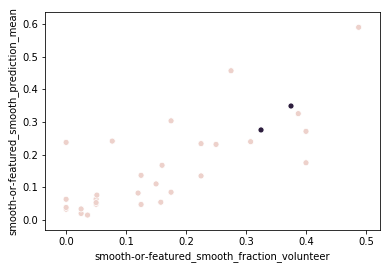

In [359]:
sns.scatterplot(data=df, x='smooth-or-featured_smooth_fraction_volunteer', y='smooth-or-featured_smooth_prediction_mean', hue='smooth-or-featured_smooth_fraction_expert', legend=False)
# sns.scatterplot(data=df, x='smooth-or-featured_smooth_fraction_expert', y='smooth-or-featured_smooth_fraction_volunteer', alpha=alpha)

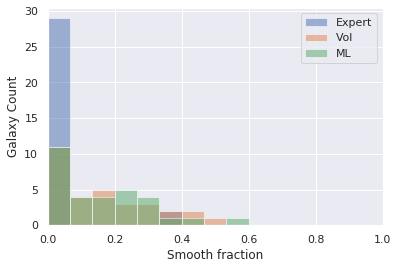

In [404]:
sns.set()
alpha = 0.5
_, bins = np.histogram(np.linspace(0., 1.), bins=15)
plt.hist(df['smooth-or-featured_smooth_fraction_expert'].values, alpha=alpha, label='Expert', bins=bins)
plt.hist(df['smooth-or-featured_smooth_fraction_volunteer'].values, alpha=alpha, label='Vol', bins=bins)
plt.hist(df['smooth-or-featured_smooth_prediction_mean'].values, alpha=alpha, label='ML', bins=bins)
plt.xlabel('Smooth fraction')
plt.ylabel('Galaxy Count')
plt.xlim(0., 1.)
plt.legend()

In [378]:
df['bar_volunteer'] = df['bar_strong_volunteer'] + df['bar_weak_volunteer']
df['bar_fraction_volunteer'] = df['bar_volunteer'] / df['bar_total-votes_volunteer']

df['bar_expert'] = df['bar_strong_expert'] + df['bar_weak_expert']
df['bar_fraction_expert'] = df['bar_expert'] / df['bar_total-votes_expert']

df['bar_prediction_mean'] = df['bar_strong_prediction_mean'] + df['bar_weak_prediction_mean']


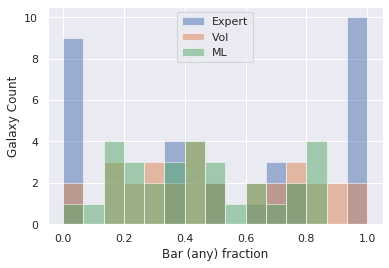

In [407]:
sns.set()
alpha = 0.5
_, bins = np.histogram(np.linspace(0., 1.), bins=15)
plt.hist(df['bar_fraction_expert'].values, alpha=alpha, bins=bins, label='Expert')
plt.hist(df['bar_fraction_volunteer'].values, alpha=alpha, bins=bins, label='Vol')
plt.hist(df['bar_prediction_mean'].values, alpha=alpha, bins=bins, label='ML')
plt.xlabel('Bar (any) fraction')
plt.ylabel('Galaxy Count')
plt.legend()

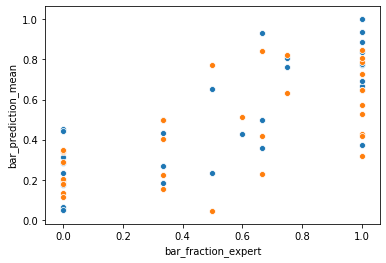

In [380]:
sns.scatterplot(data=df, x='bar_fraction_expert', y='bar_fraction_volunteer')
sns.scatterplot(data=df, x='bar_fraction_expert', y='bar_prediction_mean')

In [387]:
df['is_bar'] = df['bar_fraction_expert'] > 0.85
df['is_not_bar'] = df['bar_fraction_expert'] < 0.15
ambiguous = ~df['is_bar'] & ~df['is_not_bar']

0.9473684210526315


Text(0.5, 1, 'Volunteers')

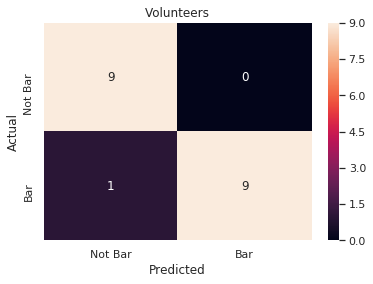

In [416]:
confident = df[~ambiguous]
print(accuracy_score(confident['is_bar'], confident['bar_fraction_volunteer'] > 0.5))
cm = confusion_matrix(confident['is_bar'], confident['bar_fraction_volunteer'] > 0.5)
sns.heatmap(cm, annot=True, xticklabels=['Not Bar', 'Bar'], yticklabels=['Not Bar', 'Bar'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Volunteers')

0.8421052631578947


Text(0.5, 1, 'ML')

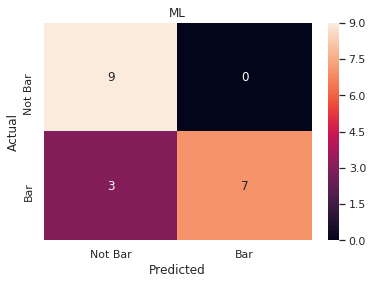

In [417]:
print(accuracy_score(confident['is_bar'], confident['bar_prediction_mean'] > 0.5))
cm = confusion_matrix(confident['is_bar'], confident['bar_prediction_mean'] > 0.5)
sns.heatmap(cm, annot=True, xticklabels=['Not Bar', 'Bar'], yticklabels=['Not Bar', 'Bar'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('ML')

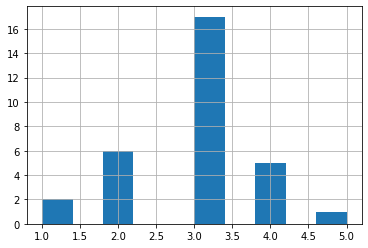

In [361]:
df['smooth-or-featured_total-votes_expert'].hist()

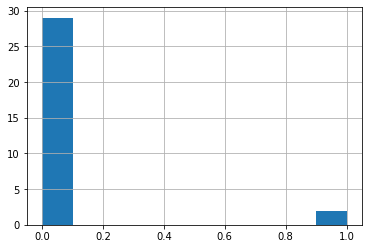

In [362]:
df['smooth-or-featured_smooth_expert'].hist()

Text(0, 0.5, 'Galaxy count')

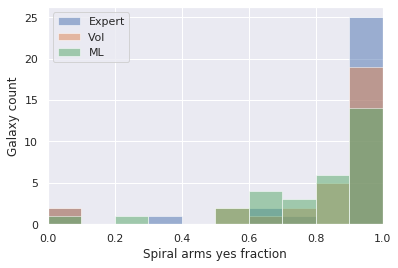

In [410]:
sns.set()
alpha = 0.5
_, bins = np.histogram(np.linspace(0., 1.))
plt.hist(df['has-spiral-arms_yes_fraction_expert'].values, alpha=alpha, bins=bins, label='Expert')
plt.hist(df['has-spiral-arms_yes_fraction_volunteer'].values, alpha=alpha, bins=bins, label='Vol')
plt.hist(df['has-spiral-arms_yes_prediction_mean'].values, alpha=alpha, bins=bins, label='ML')
plt.legend()
plt.xlim(0., 1.)
plt.xlabel('Spiral arms yes fraction')
plt.ylabel('Galaxy count')

In [ ]:
# df['is_smooth'] = df['smooth-or-featured_smooth_fraction_expert'] > 0.75
# df['is_not_smooth'] = df['smooth-or-featured_smooth_fraction_expert'] < 0.25
# ambiguous = ~is_spiral & ~is_not_spiral

In [ ]:
accuracy_score(confident['is_spiral'], confident['has-spiral-arms_yes_prediction_mean'] > 0.5)

In [365]:
mean_absolute_error(df['has-spiral-arms_yes_fraction_volunteer'], df['has-spiral-arms_yes_prediction_mean'])

0.11087559423075653

In [366]:
confident = df[~ambiguous]
accuracy_score(confident['is_spiral'], confident['has-spiral-arms_yes_fraction_volunteer'] > 0.5)

/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


0.84

In [367]:
accuracy_score(confident['is_spiral'], confident['has-spiral-arms_yes_prediction_mean'] > 0.5)

0.84

In [374]:
accuracy_score(confident['is_spiral'], (confident['has-spiral-arms_yes_prediction_mean'] + confident['has-spiral-arms_yes_fraction_volunteer'] / 2)> 0.5)

0.8

In [368]:
mean_squared_error(df['has-spiral-arms_yes_fraction_volunteer'], df['has-spiral-arms_yes_prediction_mean'])

0.023584859869389366

In [369]:
mean_absolute_error(df['has-spiral-arms_yes_fraction_volunteer'], df['has-spiral-arms_yes_prediction_mean'])

0.11087559423075653

In [370]:
mean_absolute_error(df['smooth-or-featured_smooth_fraction_volunteer'], df['smooth-or-featured_smooth_prediction_mean'])

0.06684759725560098

In [371]:
mean_squared_error(df['has-spiral-arms_yes_fraction_expert'], df['has-spiral-arms_yes_prediction_mean'])

0.03871982267021459

In [372]:
mean_squared_error(df['smooth-or-featured_smooth_fraction_volunteer'], df['smooth-or-featured_smooth_prediction_mean'])

0.008618609399430866

In [373]:
mean_absolute_error(df['smooth-or-featured_smooth_fraction_volunteer'], df['smooth-or-featured_smooth_prediction_mean'])

0.06684759725560098